**GW20_34_PFC**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/GW20_02_20240209_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/GW20_34_PFC/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-GW20_34_PFC-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 11681 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


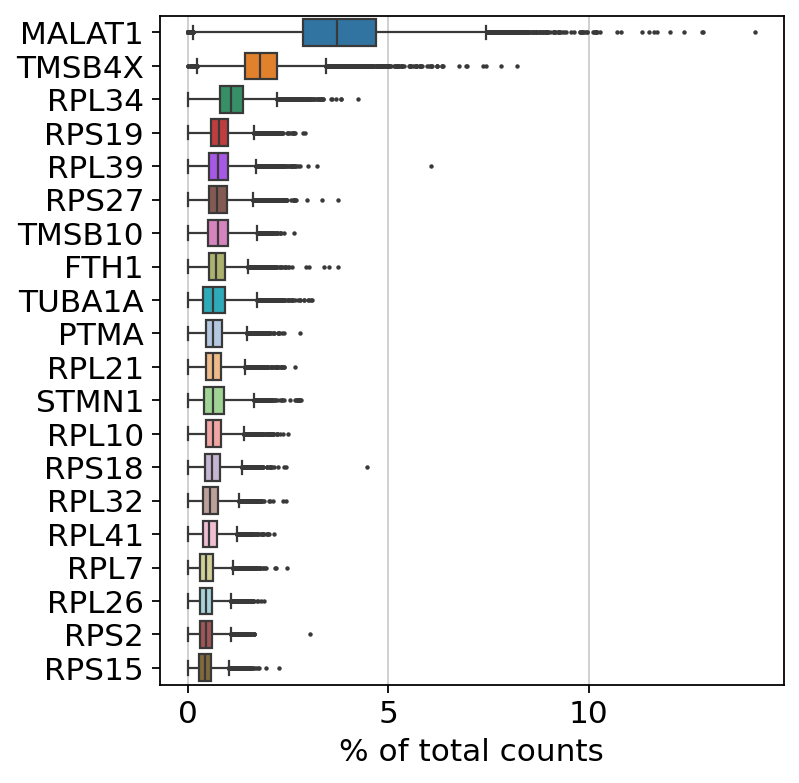

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 1 cells that have less than 100 genes expressed
filtered out 22656 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

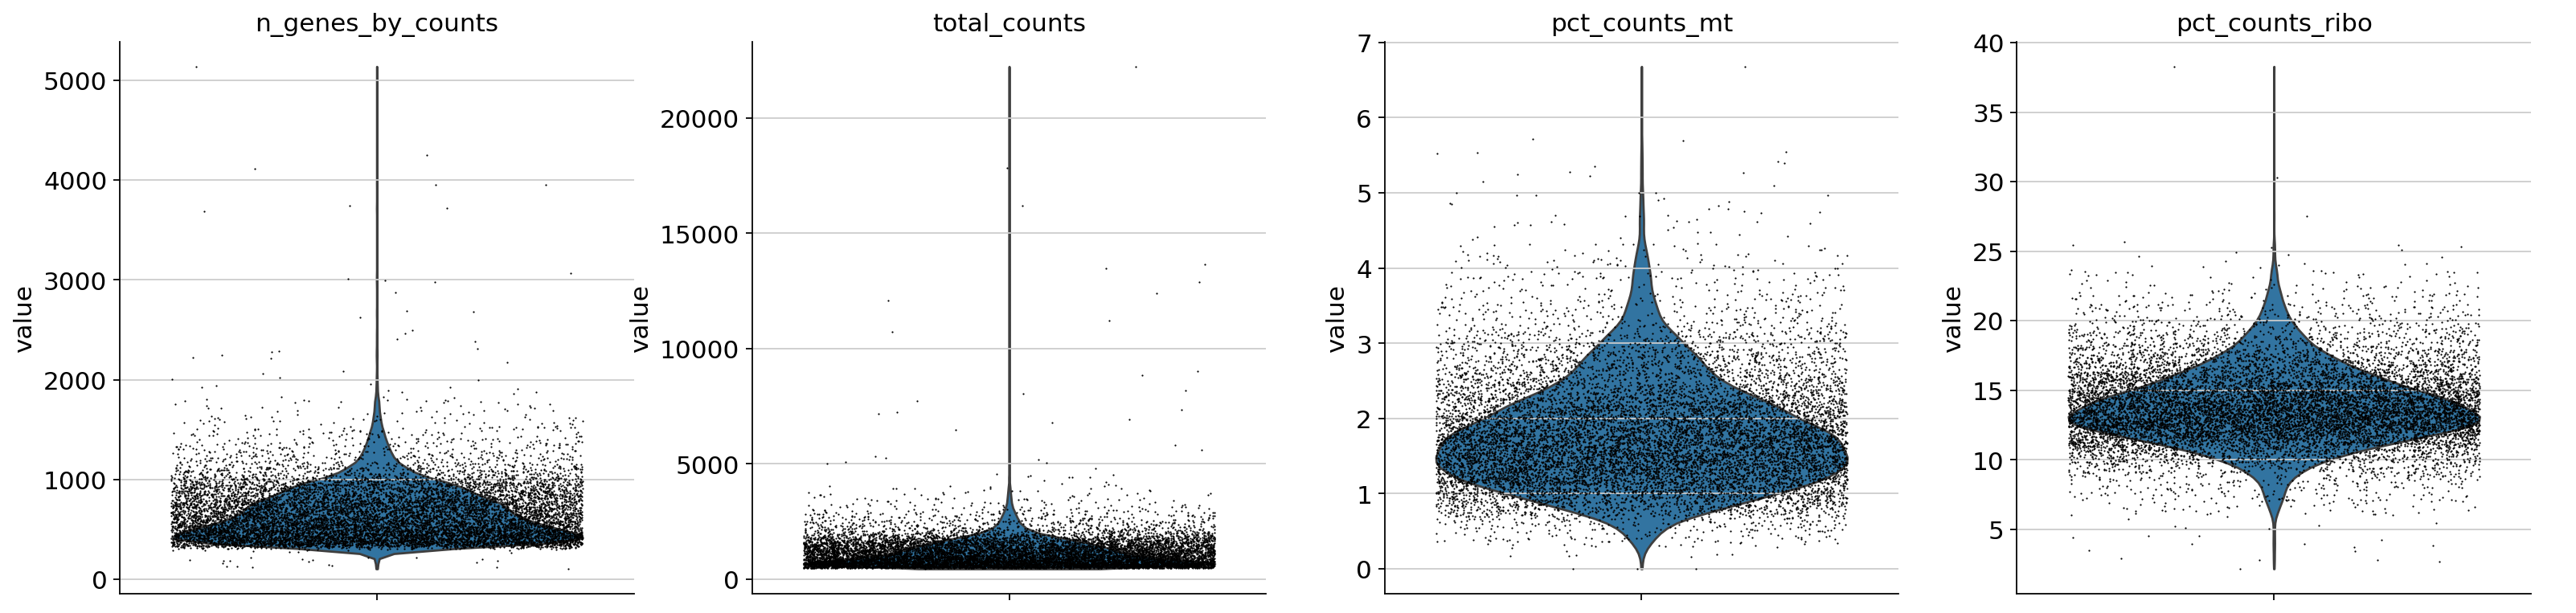

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

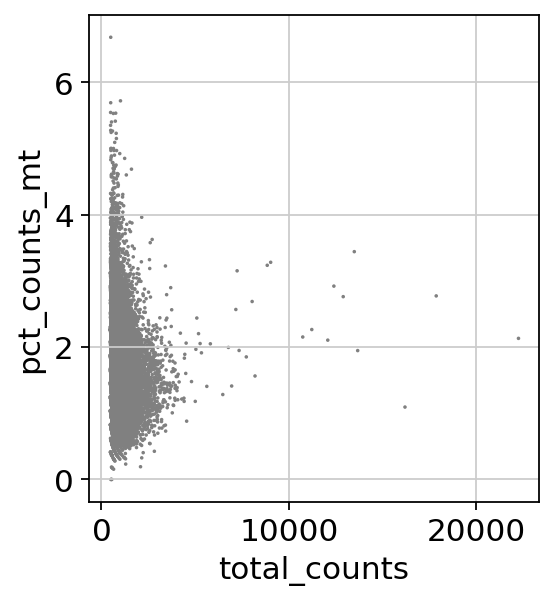

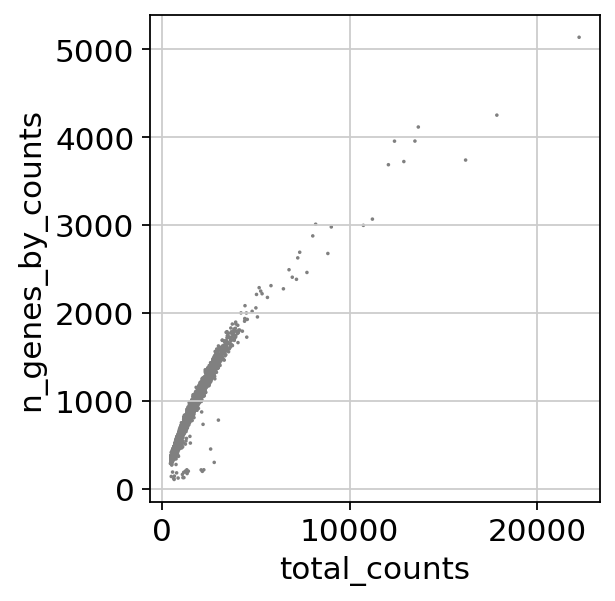

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 4000]

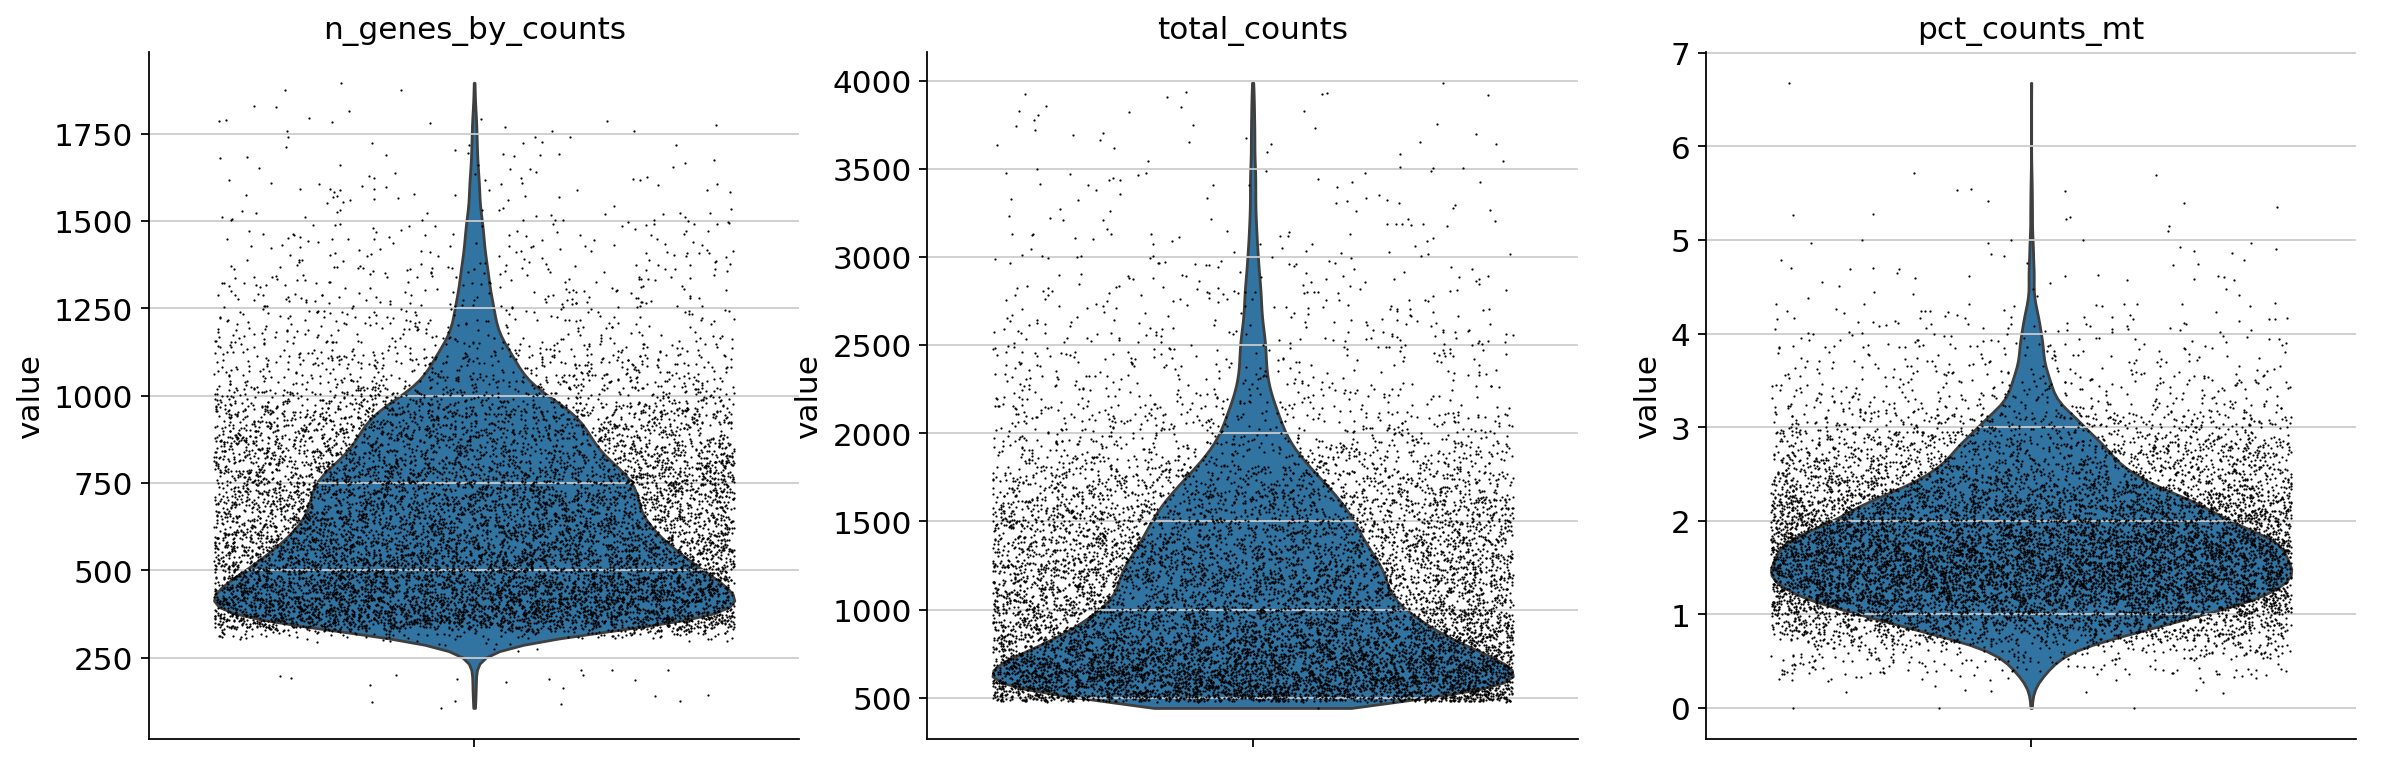

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    686 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    729 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G1     6729
S      3850
G2M    1056
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.5%
    Scrublet finished (0:00:10)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    11633
True         2
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=4000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 11635 × 11038
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)


Index(['SRGN', 'CXCL8', 'CCNB2', 'SPP1', 'NUSAP1', 'PBK', 'TOP2A', 'GTSE1',
       'DLGAP5', 'APOD', 'CDC20', 'BIRC5', 'CCL4L2', 'MKI67', 'CDK1', 'AURKB',
       'SLCO1C1', 'UBE2C', 'CCL4', 'RGS10'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['HES4', 'PRDM16', 'SRM', 'PDPN', 'KAZN', 'IGSF21', 'ID3', 'FABP3',
       'HPCA', 'GRIK3',
       ...
       'CENPM', 'GTSE1', 'BTG3', 'JAM2', 'OLIG2', 'OLIG1', 'PSMG1', 'PCP4',
       'C21orf58', 'S100B'],
      dtype='object', length=703)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


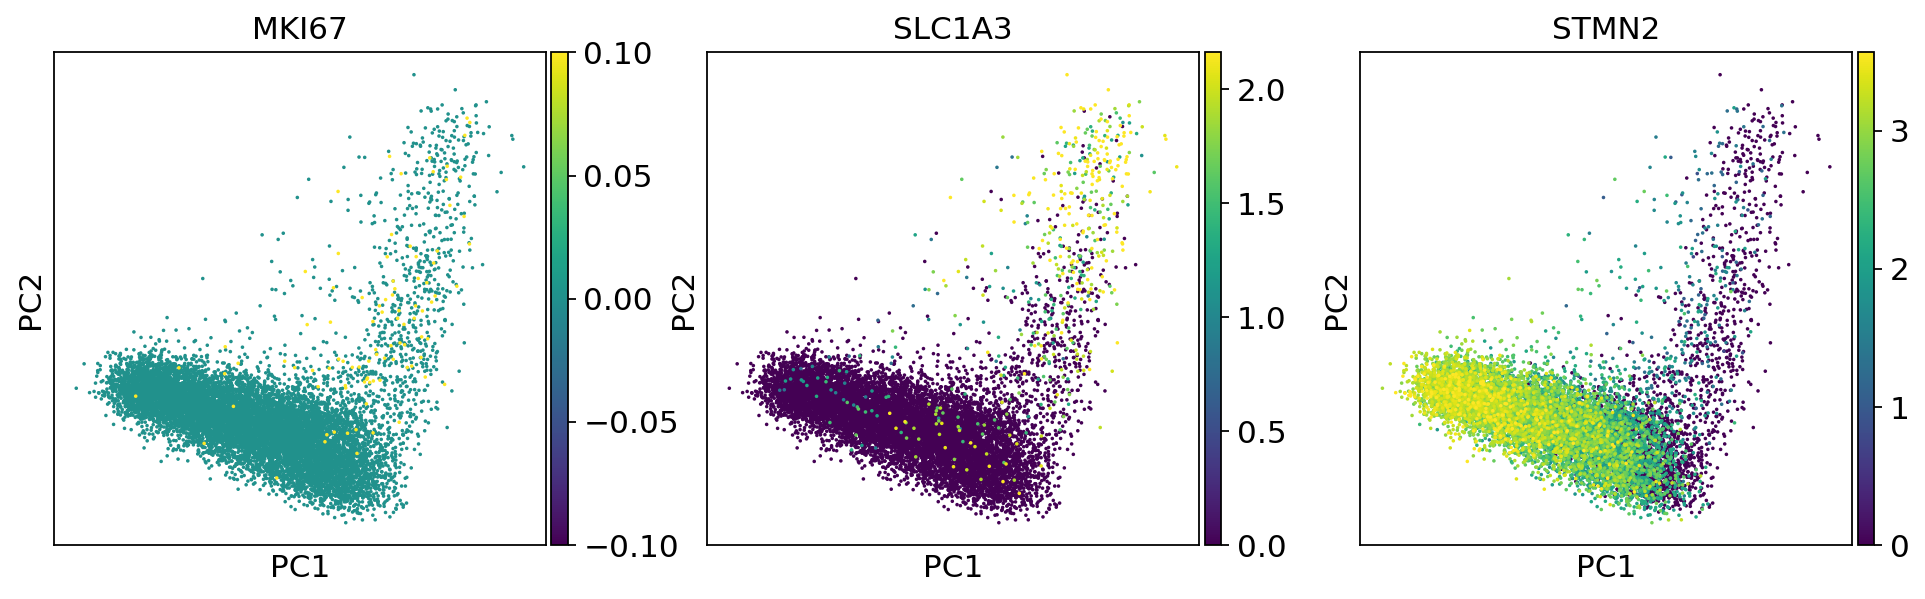

In [25]:

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") 

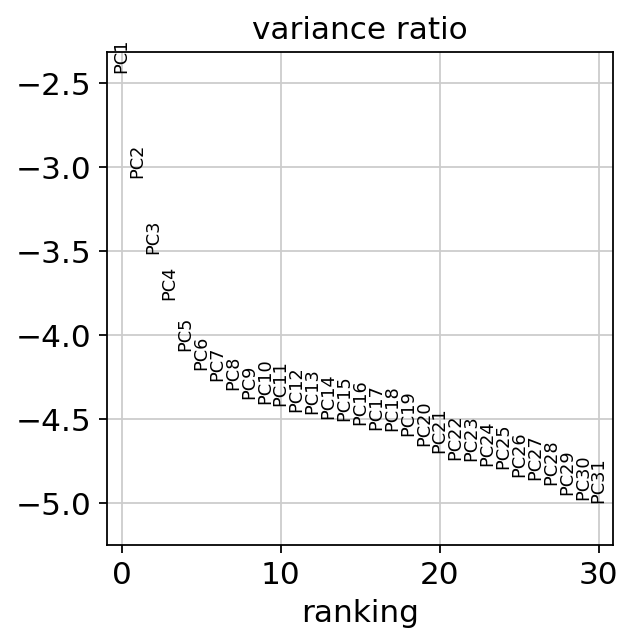

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 11635 × 11038
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

53

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


In [32]:
adata.obs.leiden.value_counts()

0    3111
1    2862
2    1894
3    1783
4     743
5     646
6     596
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


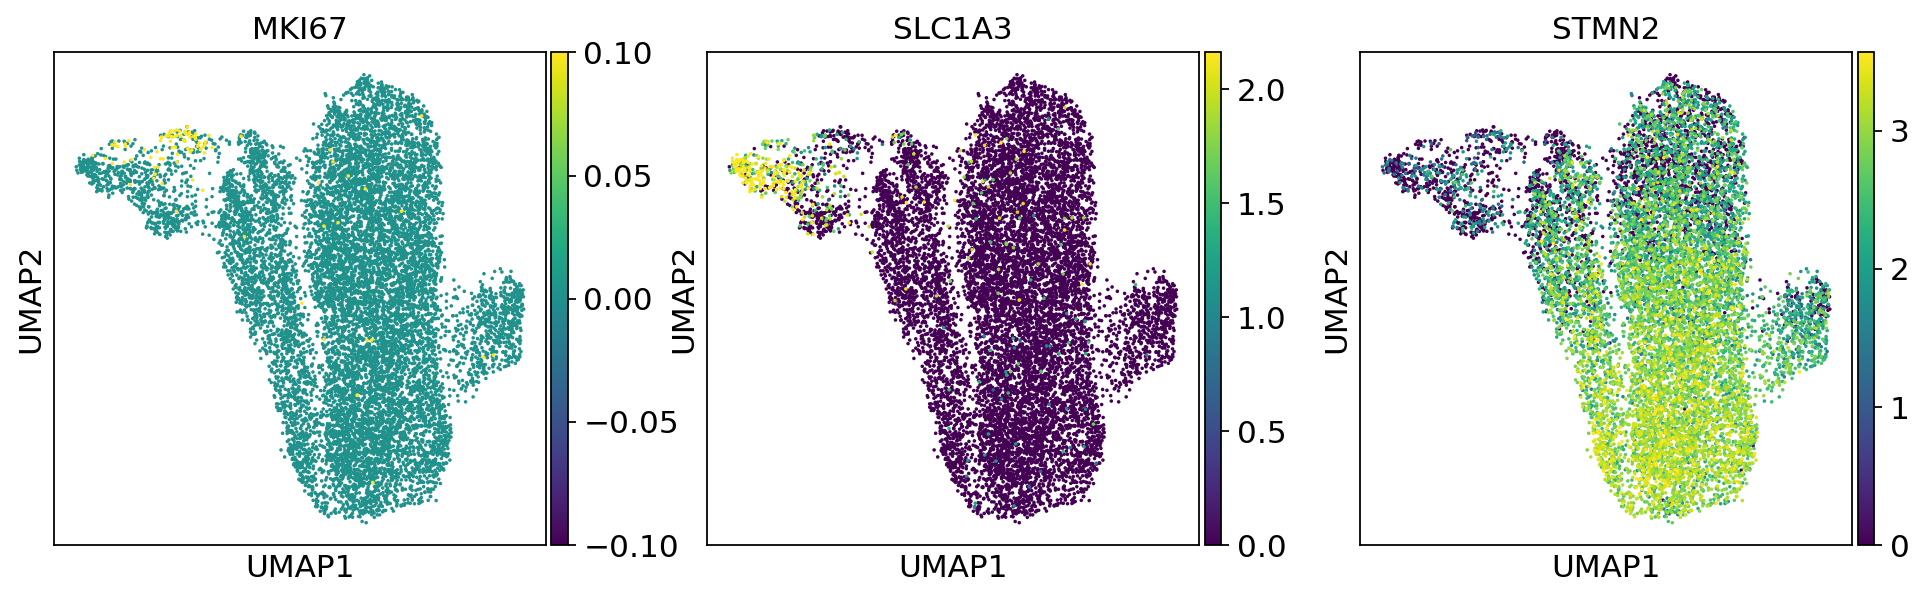

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

In [ ]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


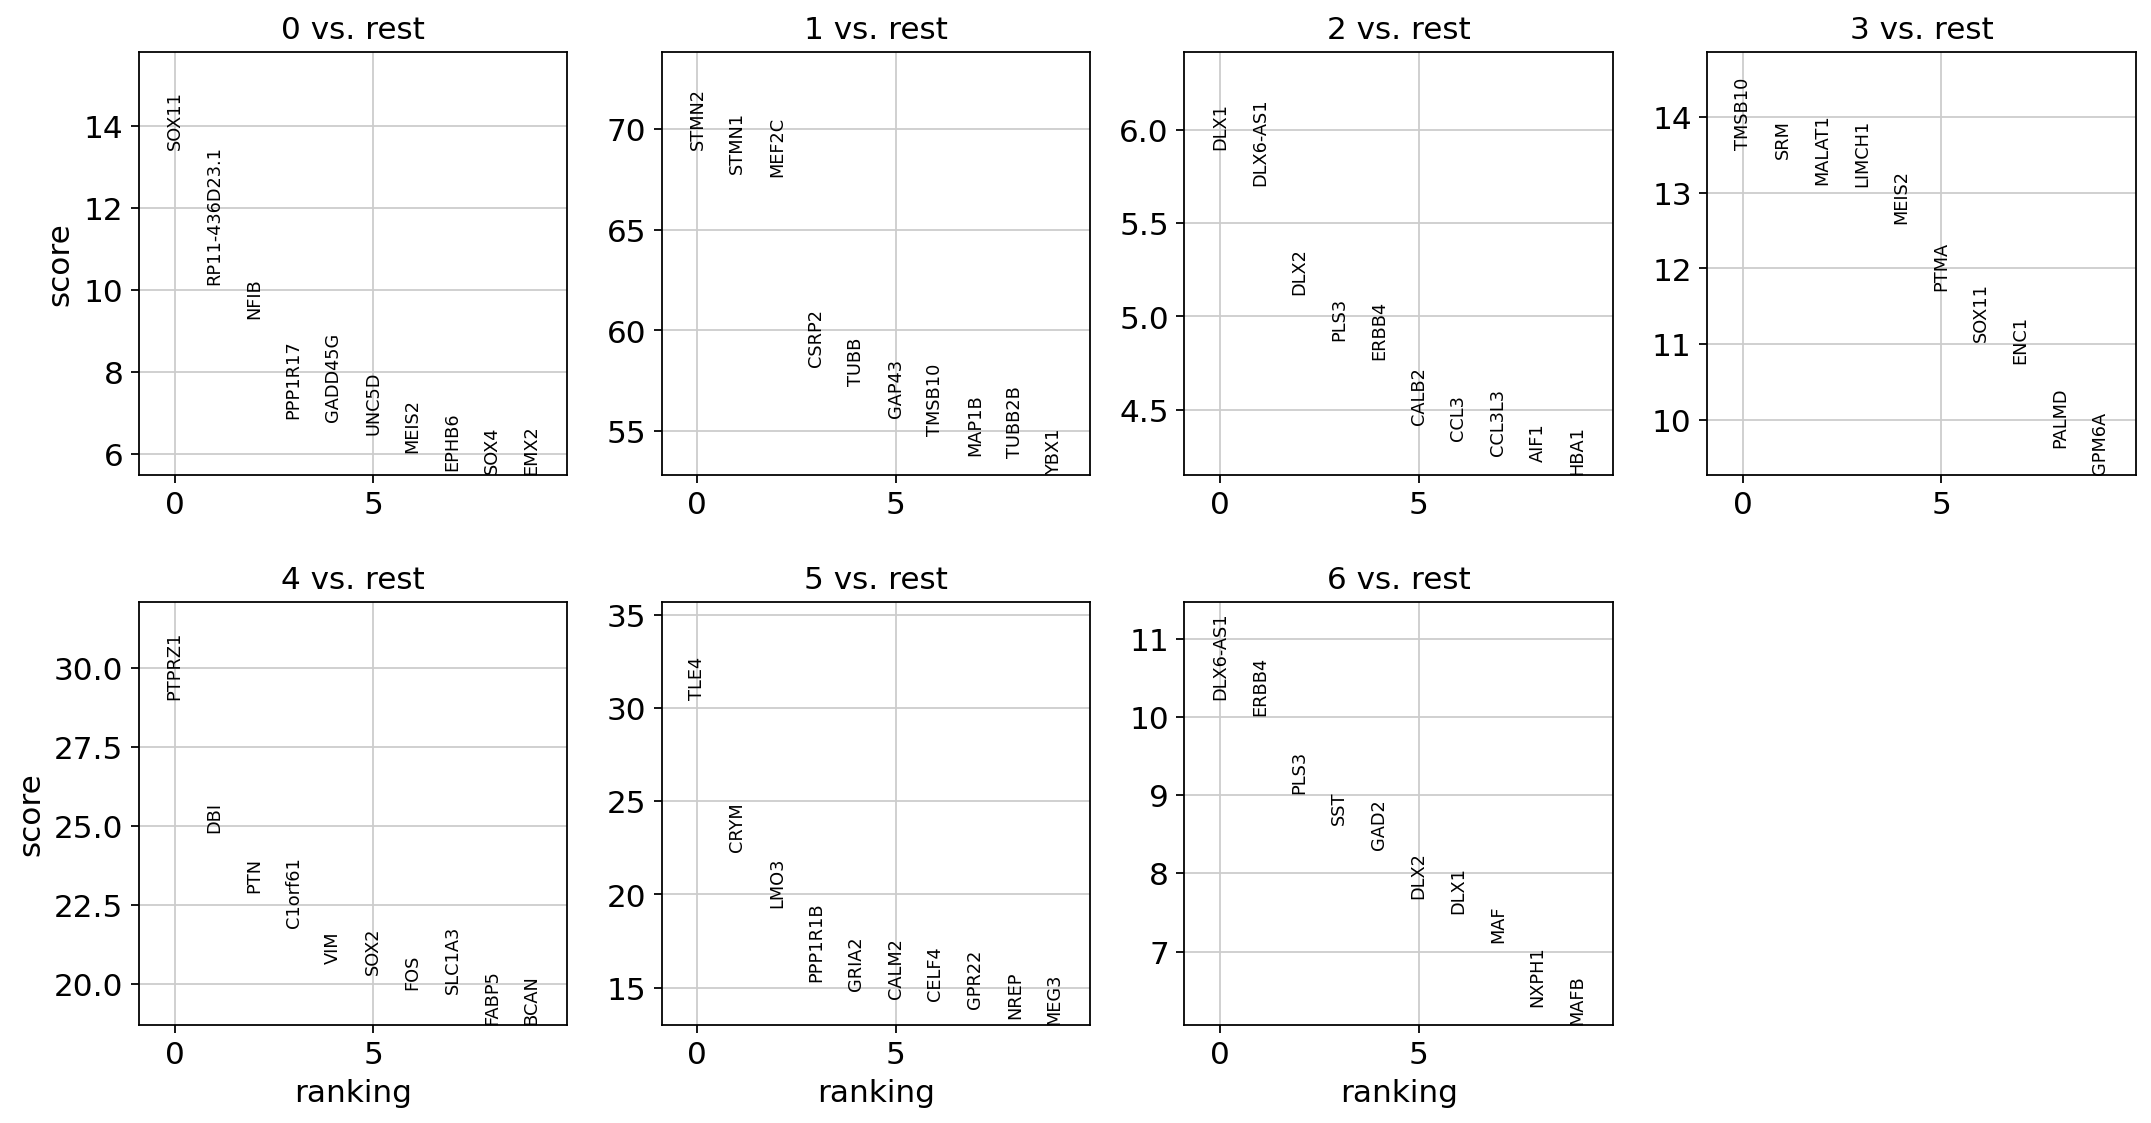

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [37]:
#result.keys()

In [38]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p    1_n  1_p       2_n           2_p     3_n  \
0          SOX11  1.300033e-40  STMN2  0.0      DLX1  4.346705e-09  TMSB10   
1  RP11-436D23.1  6.360929e-24  STMN1  0.0  DLX6-AS1  1.332376e-08     SRM   
2           NFIB  1.746433e-20  MEF2C  0.0      DLX2  3.383493e-07  MALAT1   
3        PPP1R17  6.808086e-12  CSRP2  0.0      PLS3  1.196267e-06  LIMCH1   
4        GADD45G  1.134827e-11   TUBB  0.0     ERBB4  1.931903e-06   MEIS2   

            3_p      4_n            4_p      5_n            5_p       6_n  \
0  1.267329e-40   PTPRZ1  2.191669e-124     TLE4  1.845948e-127  DLX6-AS1   
1  9.274315e-40      DBI   1.985877e-99     CRYM   2.255309e-82     ERBB4   
2  5.887508e-38      PTN   2.614556e-88     LMO3   3.896663e-66      PLS3   
3  1.020018e-37  C1orf61   5.543501e-82  PPP1R1B   1.914536e-45       SST   
4  3.362431e-35      VIM   3.271331e-75    GRIA2   2.477483e-43      GAD2   

            6_p  
0  9.276744e-23  
1  5.560202e-22  
2  2.342953e-18  
3  5.565052e-17  
4  6.229632e-16

In [ ]:
adata.write(results_file)

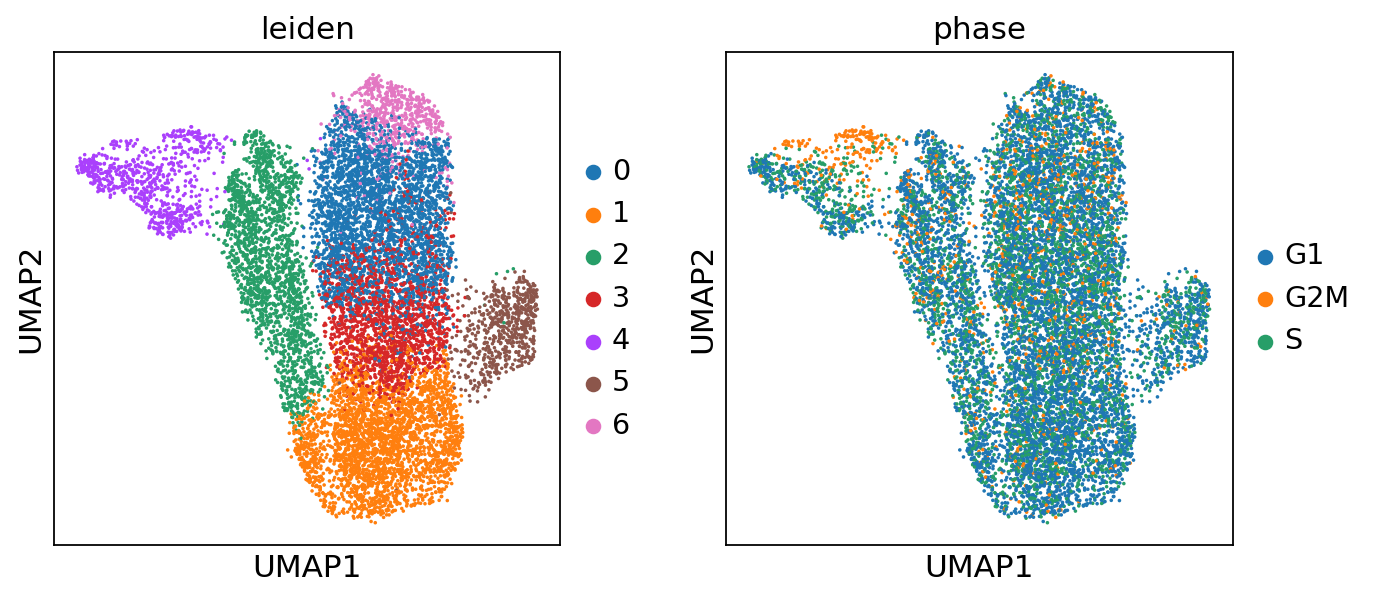

In [39]:
sc.pl.umap(adata,color=["leiden","phase"])

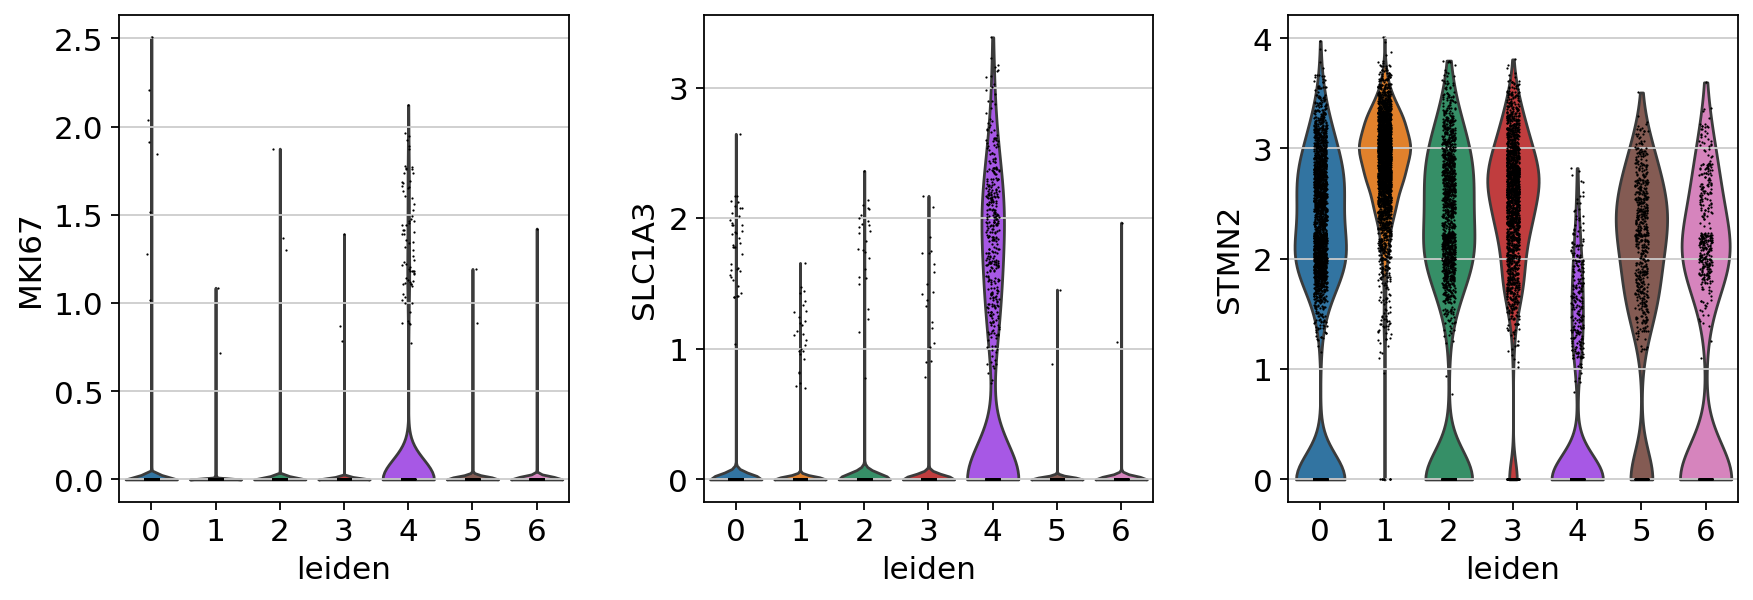

In [40]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [41]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1         2       3        4        5         6
0          SOX11   STMN2      DLX1  TMSB10   PTPRZ1     TLE4  DLX6-AS1
1  RP11-436D23.1   STMN1  DLX6-AS1     SRM      DBI     CRYM     ERBB4
2           NFIB   MEF2C      DLX2  MALAT1      PTN     LMO3      PLS3
3        PPP1R17   CSRP2      PLS3  LIMCH1  C1orf61  PPP1R1B       SST
4        GADD45G    TUBB     ERBB4   MEIS2      VIM    GRIA2      GAD2
5          UNC5D   GAP43     CALB2    PTMA     SOX2    CALM2      DLX2
6          MEIS2  TMSB10      CCL3   SOX11      FOS    CELF4      DLX1
7          EPHB6   MAP1B    CCL3L3    ENC1   SLC1A3    GPR22       MAF
8           SOX4  TUBB2B      AIF1   PALMD    FABP5     NREP     NXPH1
9           EMX2    YBX1      HBA1   GPM6A     BCAN     MEG3      MAFB

In [42]:
marker_genes = ['leiden','SOX11', 'STMN2','STMN1','DLX1','TMSB10','DBI','PTPRZ1','TLE4','CRYM','ERBB4','DLX6-AS1']

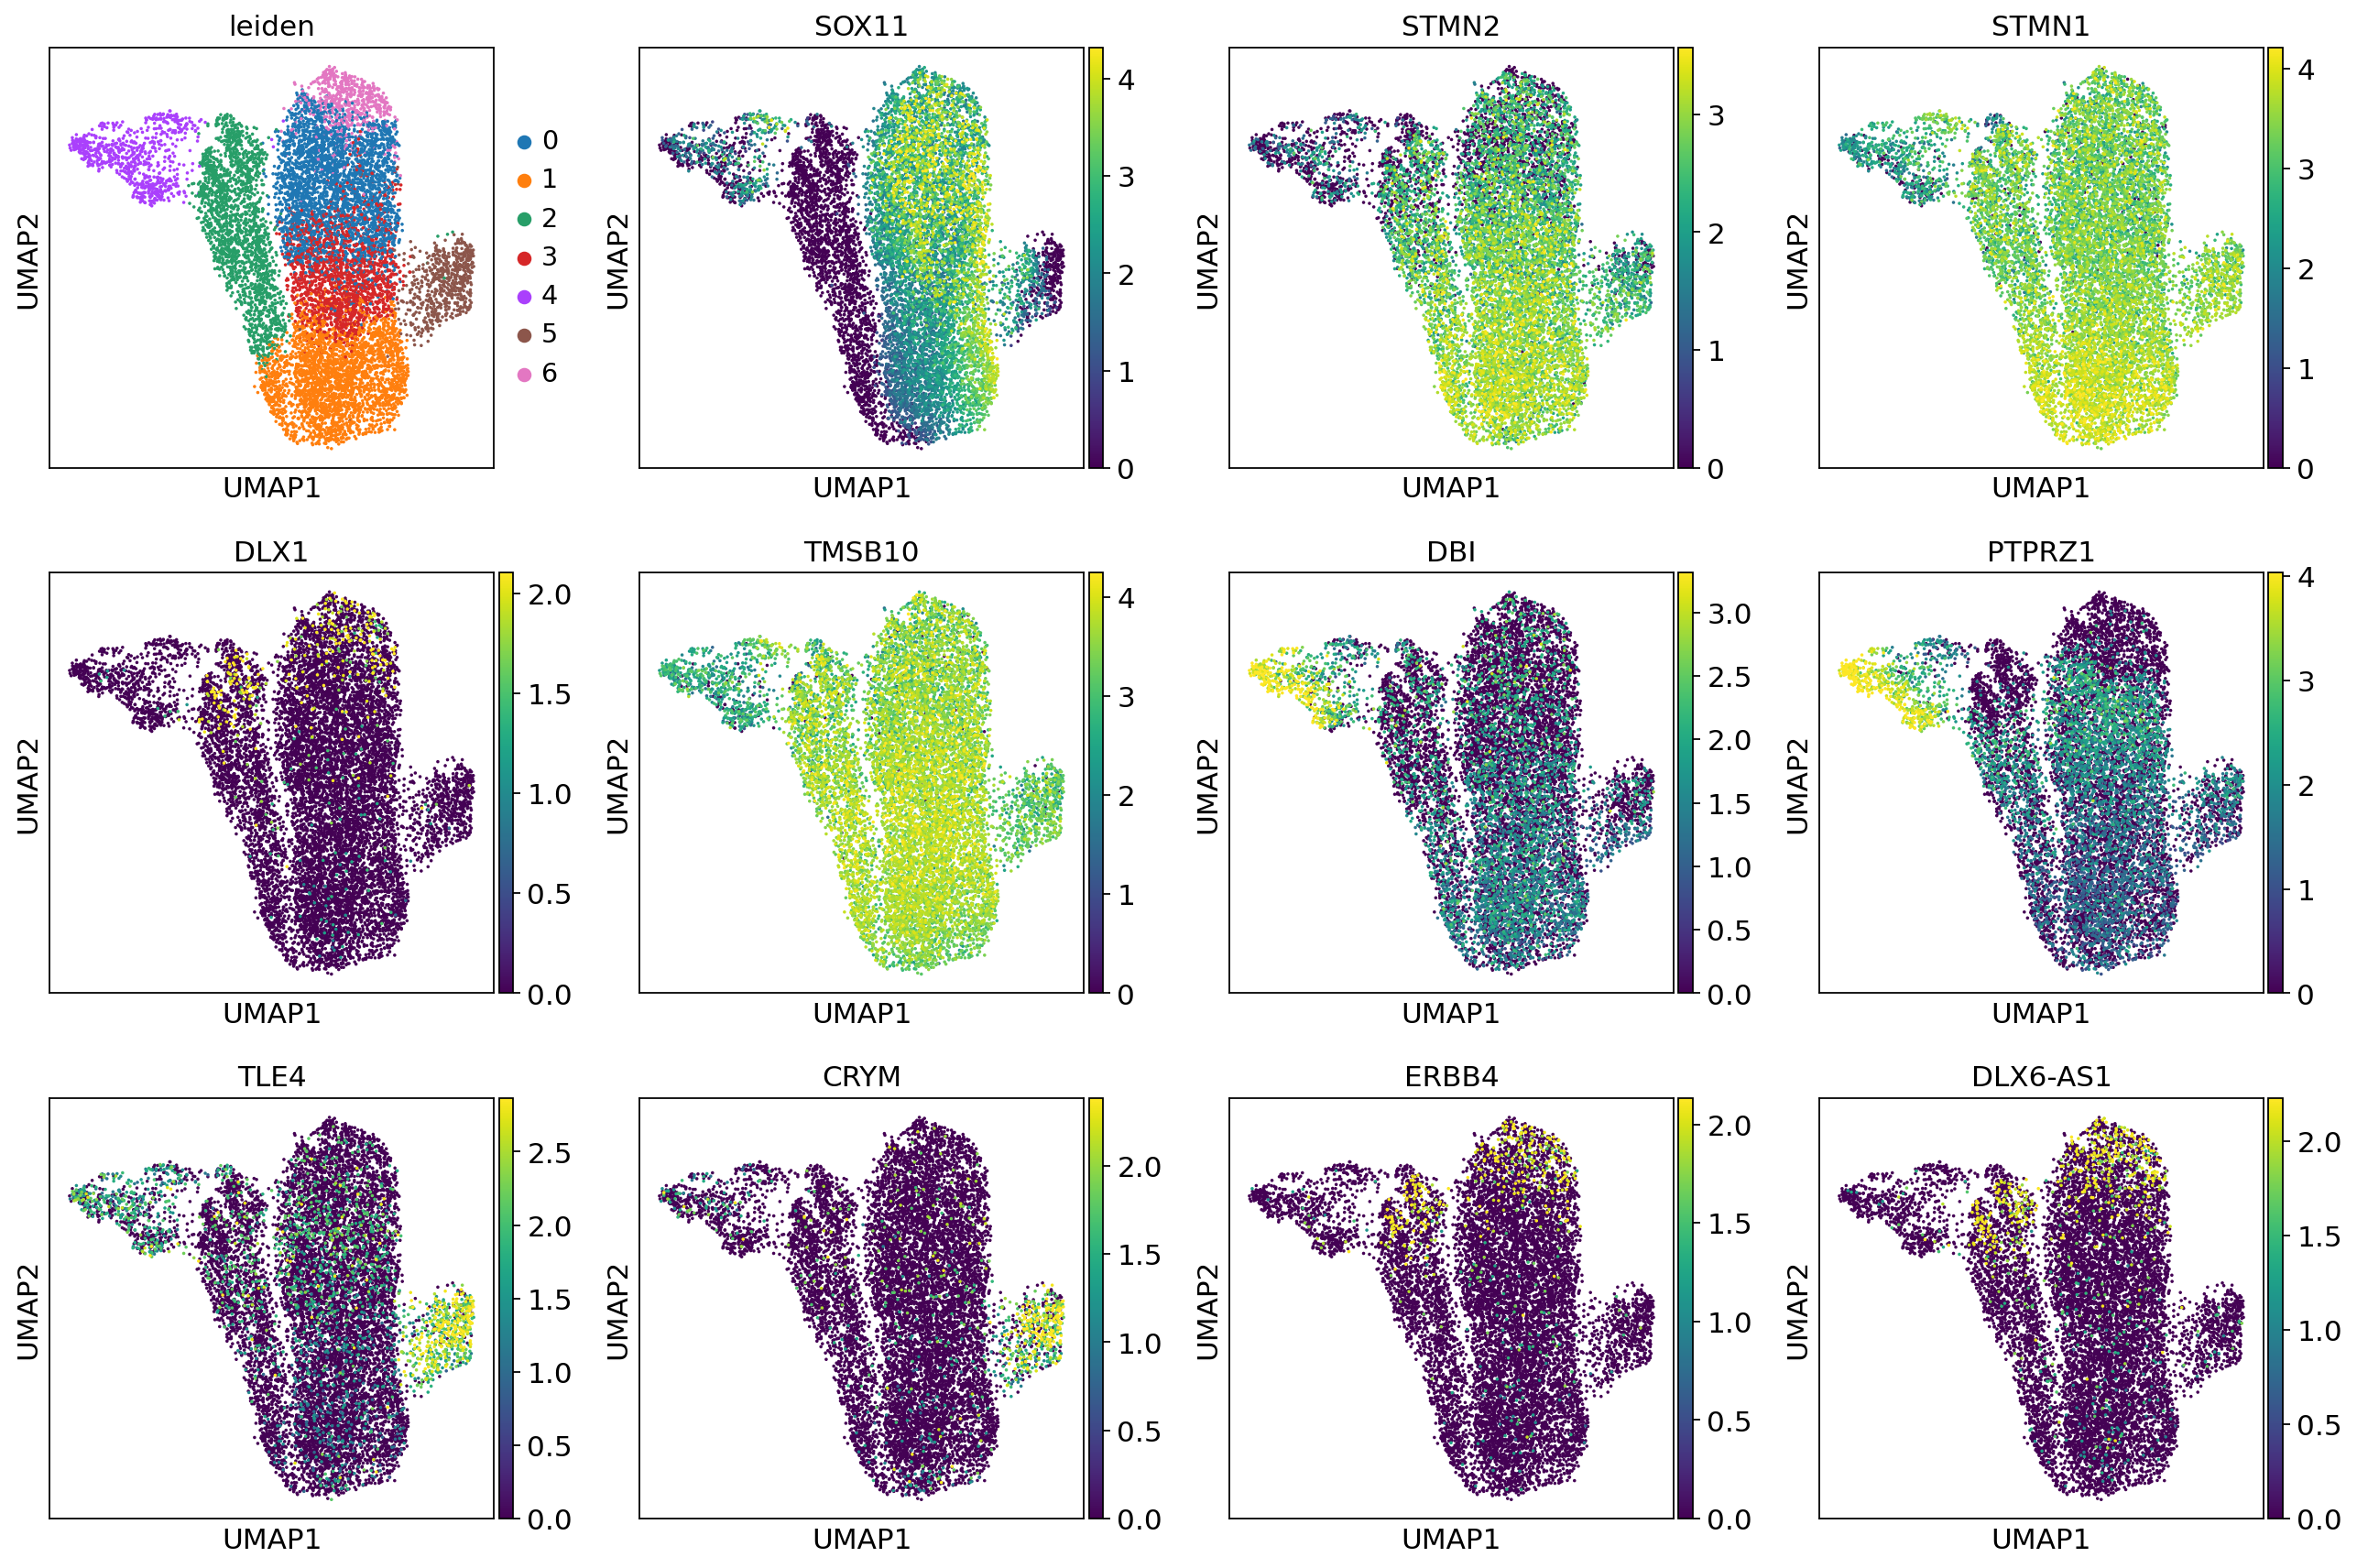

In [43]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [44]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98550534 0.97357494 0.94879985 0.94185346 0.93163306
     0.92815405 0.92681295 0.9110183  0.8928403  0.88157433 0.87716925
     0.87060374 0.8665     0.861403  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


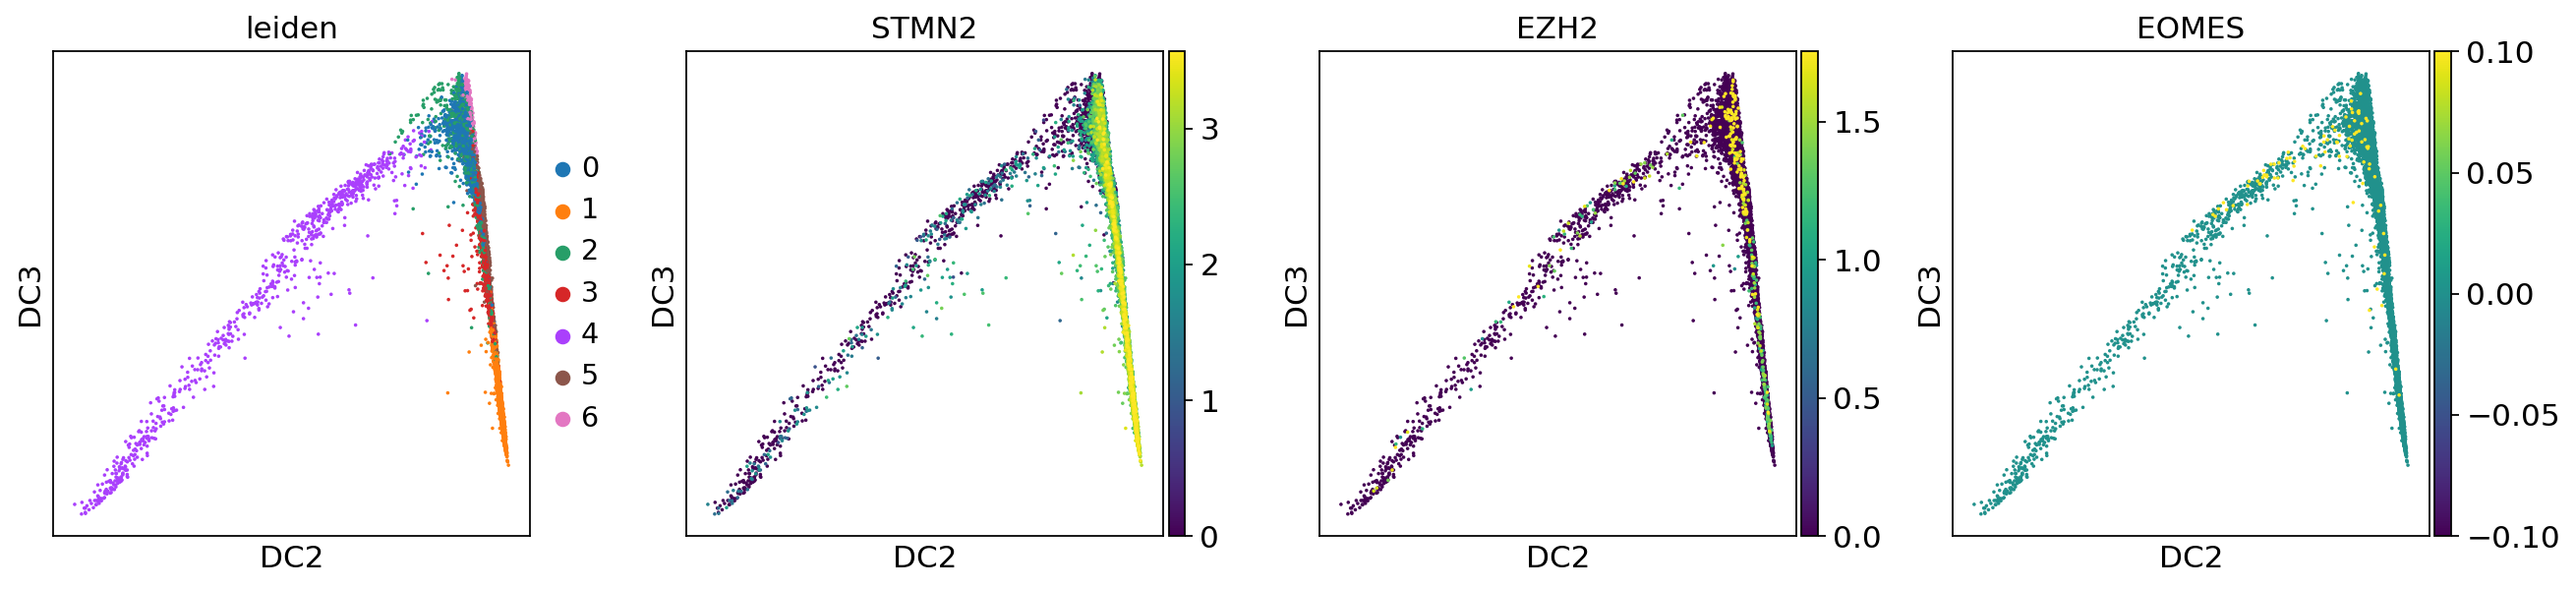

In [45]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2', 'EOMES'],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [46]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: astrocytes, microglia, endothelial, etc.


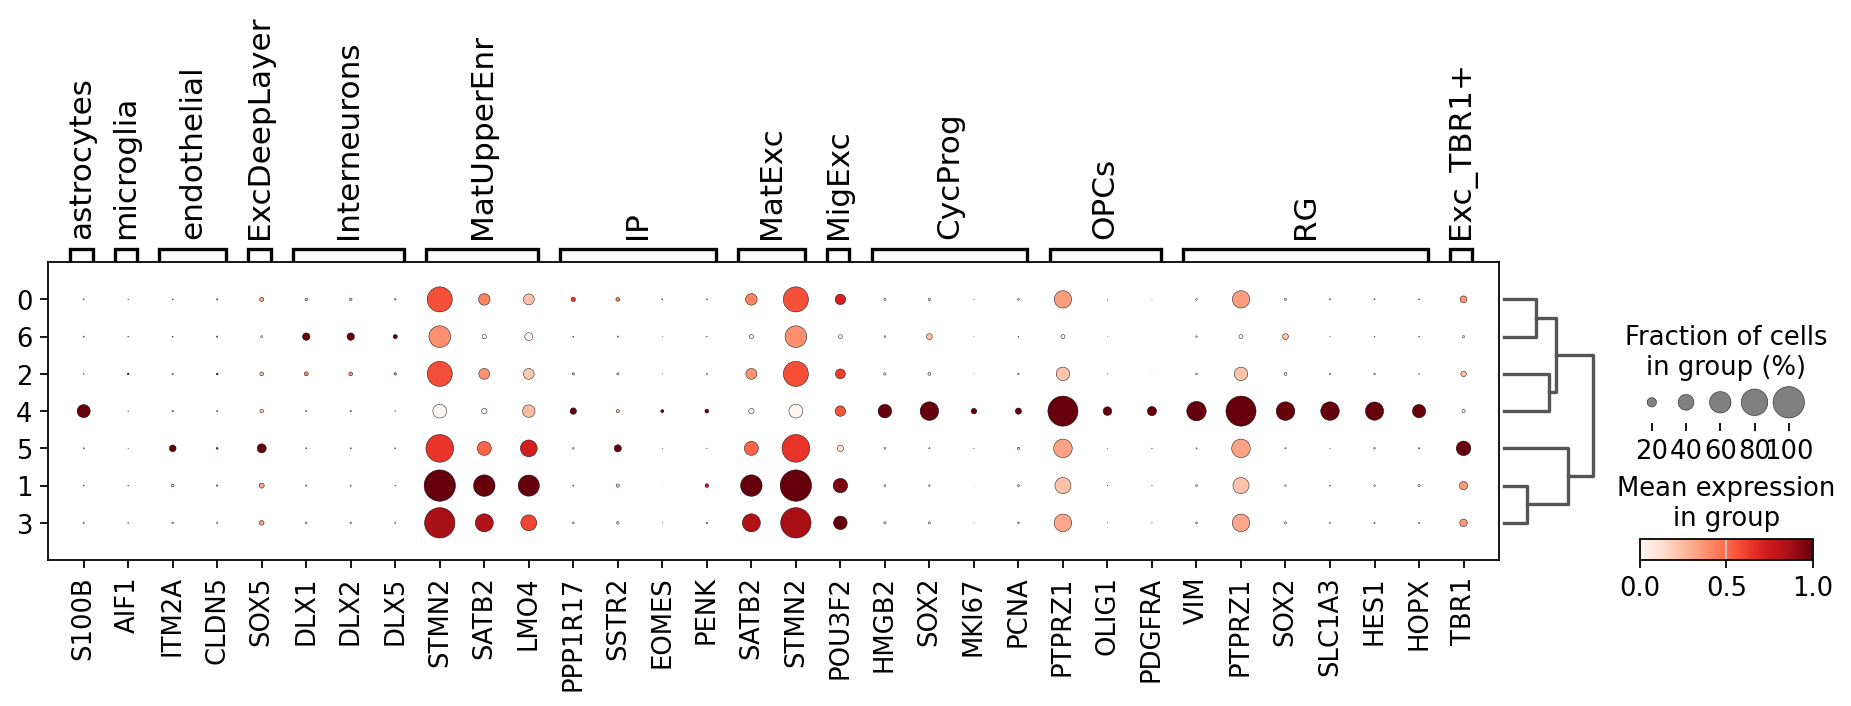

In [47]:
geschwind_ext = {
  'astrocytes' : ['S100B'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_TBR1+' : ['TBR1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [48]:
cluster2annotation = {
     "0": "Neu", "1": "Neu", "2":"Neu", "3": "Neu",
    "4": "RG", "5" : "Neu", "6": "Neu"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [49]:

cluster2annotation = {
     "0": "MigExc", "1": "MatUpp","2":"MigExc", "3": "MigExc",
    "4": "oRG", "5" : "DeepLayer", "6": "Interneuron"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [50]:
new_cluster_names = [
    '0/MigExc', '1/MatUpp',
    '2/MigExc', '3/MigExc',
    '4/oRG','5/DeepLayer',
    '6/Interneuron']
adata.rename_categories('leiden', new_cluster_names)

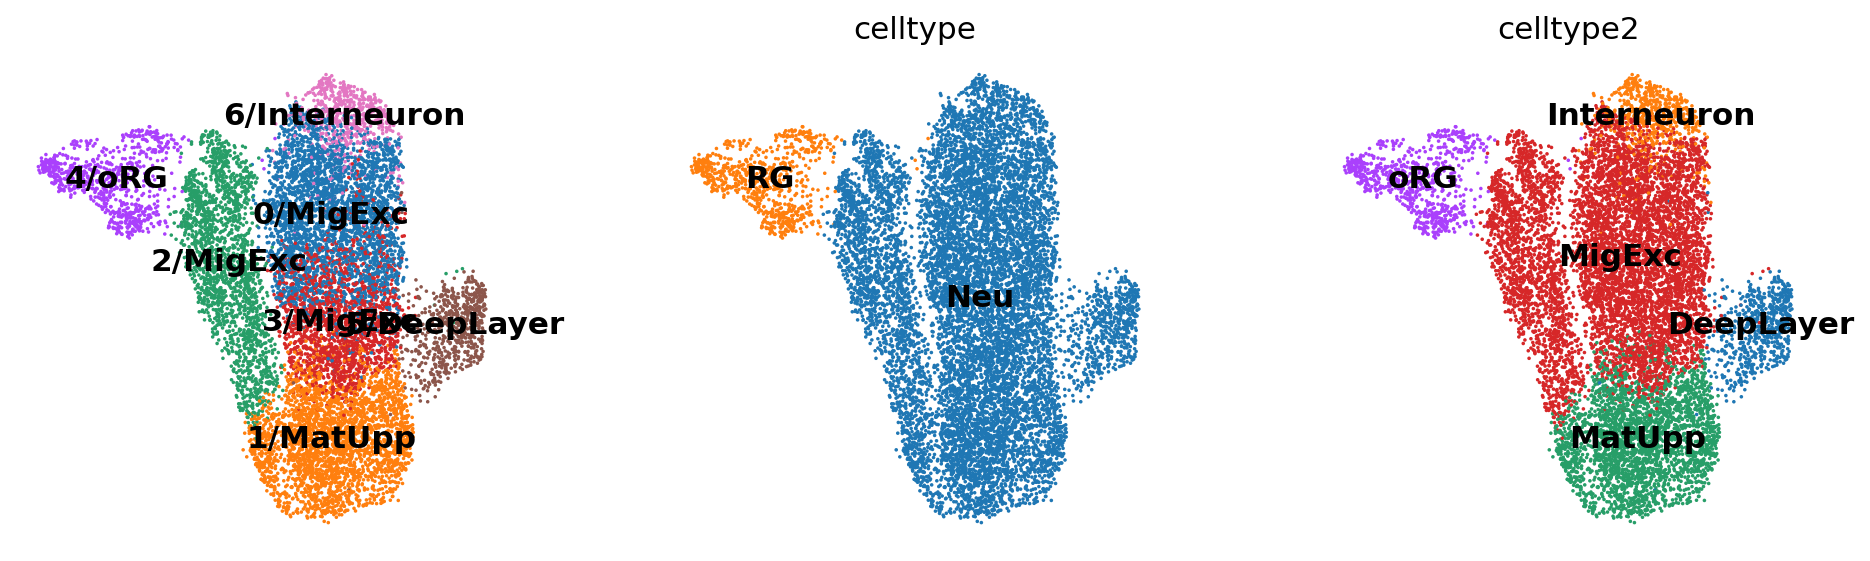

In [51]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

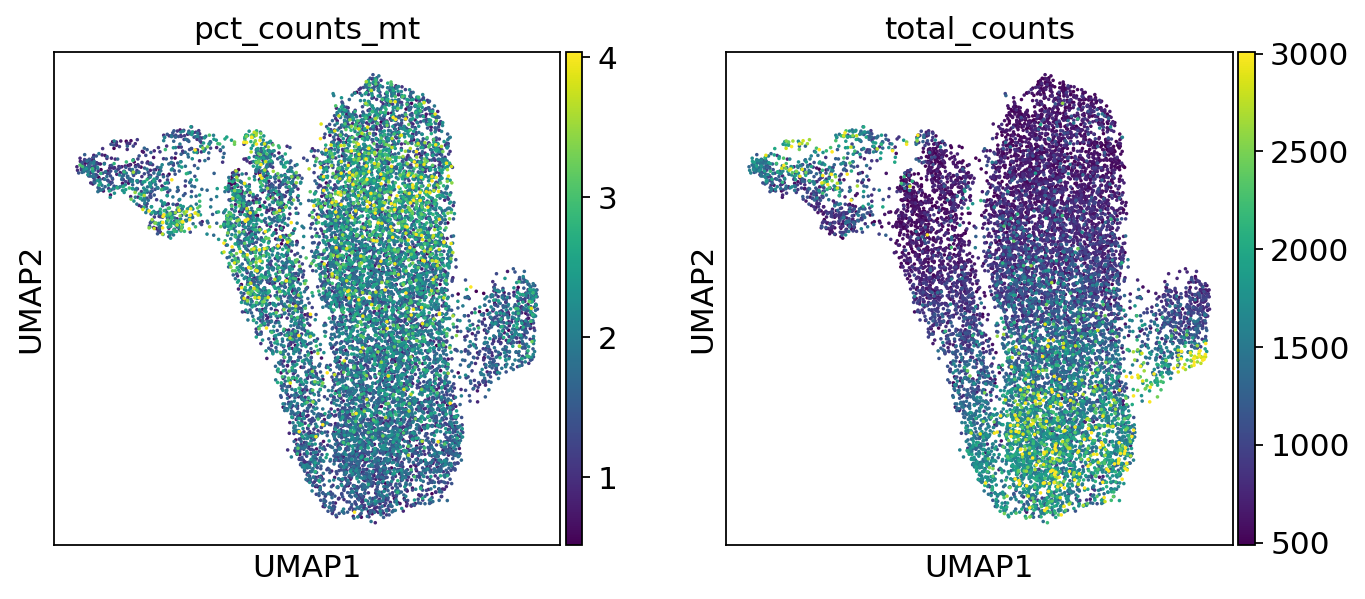

In [52]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [53]:
sc.tl.dendrogram(adata,"leiden")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [54]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98550534 0.97357494 0.94879985 0.94185346 0.93163306
     0.92815405 0.92681295 0.9110183  0.8928403  0.88157433 0.87716925
     0.87060374 0.8665     0.861403  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [55]:
adata.obs.leiden.value_counts()

0/MigExc         3111
1/MatUpp         2862
2/MigExc         1894
3/MigExc         1783
4/oRG             743
5/DeepLayer       646
6/Interneuron     596
Name: leiden, dtype: int64

In [56]:
#adata_check = adata[~adata.obs.celltype.isin(['', ''])].copy()

In [57]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98550534 0.97357494 0.94879985 0.94185346 0.93163306
     0.92815405 0.92681295 0.9110183  0.8928403  0.88157433 0.87716925
     0.87060374 0.8665     0.861403  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


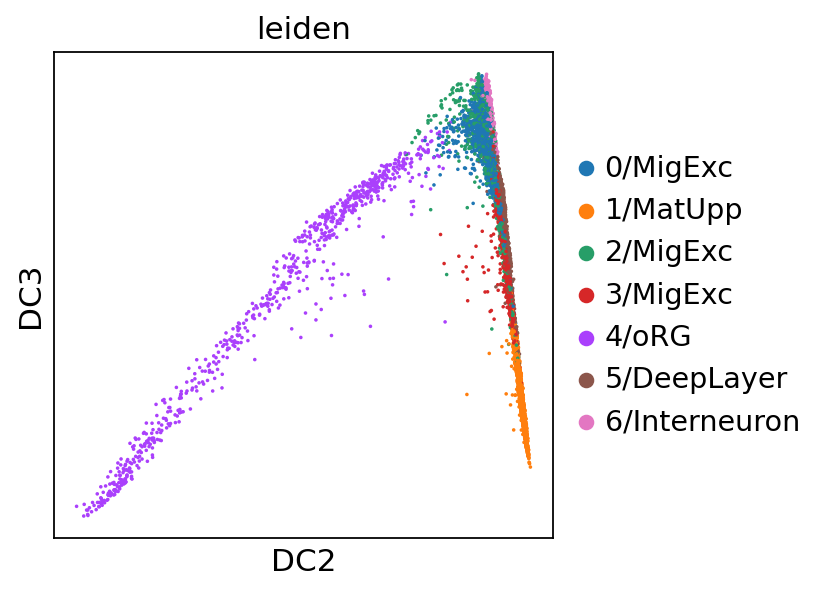

In [58]:
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [65]:
adata.obs.leiden

AAACCTGAGAGTAAGG-1    3/MigExc
AAACCTGAGCACGCCT-1    0/MigExc
AAACCTGAGGCCGAAT-1    1/MatUpp
AAACCTGAGGTAGCCA-1    2/MigExc
AAACCTGAGTAATCCC-1    1/MatUpp
                        ...   
TTTGTCAGTGCGAAAC-1    1/MatUpp
TTTGTCATCGCATGAT-1    2/MigExc
TTTGTCATCGCTTAGA-1    0/MigExc
TTTGTCATCGGTTAAC-1    1/MatUpp
TTTGTCATCTCACATT-1    3/MigExc
Name: leiden, Length: 11635, dtype: category
Categories (7, object): ['0/MigExc', '1/MatUpp', '2/MigExc', '3/MigExc', '4/oRG', '5/DeepLayer', '6/Interneuron']

In [66]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW20_02_20240209_v1.h5ad")

In [67]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/GW20_02_20240209_v1.h5ad")

In [68]:
adata.obs['stage'] = 'GW20'

In [69]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/GW20_02_20240209_v1.h5ad')